In [11]:
import numpy as np

# Set numpy to print all elements
np.set_printoptions(threshold=np.inf)

# Load and print the strokes file
strokes = np.load('styles/style-10-strokes.npy')
print("Strokes Array:")
print(strokes)

# Load the chars file and print the raw numpy array
chars_array = np.load('styles/style-10-chars.npy')
print("Chars Array (raw):")
print(chars_array)

# If the chars file is stored as bytes, convert it to a string to see the content
chars_string = chars_array.tobytes().decode('utf-8')
print("Decoded Chars String:")
print(chars_string)


Strokes Array:
[[ 0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [-7.58371306e-01  1.92704676e-01  0.00000000e+00]
 [-1.14849736e+00  3.57324424e-01  0.00000000e+00]
 [-1.41366017e+00  4.66816496e-01  0.00000000e+00]
 [-1.35782303e+00  5.76528745e-01  0.00000000e+00]
 [-1.17604407e+00  2.94837909e-01  0.00000000e+00]
 [-1.09548828e+00  1.47584333e+00  0.00000000e+00]
 [-8.70789298e-01  2.20519028e+00  0.00000000e+00]
 [-4.80144604e-01  2.34633905e+00  0.00000000e+00]
 [-2.14756725e-01  1.91581768e+00  0.00000000e+00]
 [-8.27673554e-02  1.08139200e+00  0.00000000e+00]
 [ 4.14737060e-01 -4.11292498e-02  0.00000000e+00]
 [ 6.26597221e-01  3.20696591e-01  0.00000000e+00]
 [ 8.03913901e-01  1.30526409e-01  0.00000000e+00]
 [ 9.69683469e-01 -1.36642465e-01  0.00000000e+00]
 [ 7.55631313e-01 -4.52720211e-01  0.00000000e+00]
 [ 4.07045509e-01 -5.15402440e-01  0.00000000e+00]
 [ 9.10988908e-01 -1.45417781e+00  0.00000000e+00]
 [ 1.13059933e+00 -1.88690097e+00  0.00000000e+00]
 [ 1.05434925e+0

In [10]:
import tkinter as tk
from tkinter import simpledialog, messagebox
import numpy as np
import os
import drawing


class HandwritingRecorder:
    def __init__(self, master):
        self.master = master
        master.title("Handwriting Style Recorder")

        # Create a larger drawing canvas (double size).
        self.canvas = tk.Canvas(master, width=1600, height=1200, bg="white")
        self.canvas.pack(padx=20, pady=20)

        # Bind mouse events to record strokes.
        self.canvas.bind("<ButtonPress-1>", self.start_stroke)
        self.canvas.bind("<B1-Motion>", self.draw)
        self.canvas.bind("<ButtonRelease-1>", self.end_stroke)

        # List to hold all strokes; each stroke is a list of (x, y) tuples.
        self.strokes = []
        # Stack for redo functionality.
        self.redo_stack = []
        self.current_stroke = []

        # Create a text field for priming text with a larger font.
        self.label = tk.Label(master, text="Enter priming text for your style:", font=("Helvetica", 32))
        self.label.pack()
        self.text_entry = tk.Entry(master, width=80, font=("Helvetica", 32))
        self.text_entry.pack(pady=(0, 20))

        # Create a frame for buttons.
        self.button_frame = tk.Frame(master)
        self.button_frame.pack(pady=20)

        # Create Save, Clear, Undo, and Redo buttons with larger size and font.
        self.save_button = tk.Button(self.button_frame, text="Save Style", command=self.save_style,
                                     font=("Helvetica", 32), width=20, height=4)
        self.save_button.grid(row=0, column=0, padx=10)

        self.clear_button = tk.Button(self.button_frame, text="Clear Canvas", command=self.clear_canvas,
                                      font=("Helvetica", 32), width=20, height=4)
        self.clear_button.grid(row=0, column=1, padx=10)

        self.undo_button = tk.Button(self.button_frame, text="Undo", command=self.undo_stroke,
                                     font=("Helvetica", 32), width=20, height=4)
        self.undo_button.grid(row=0, column=2, padx=10)

        self.redo_button = tk.Button(self.button_frame, text="Redo", command=self.redo_stroke,
                                     font=("Helvetica", 32), width=20, height=4)
        self.redo_button.grid(row=0, column=3, padx=10)

    def start_stroke(self, event):
        # Start a new stroke.
        self.current_stroke = [(event.x, event.y)]

    def draw(self, event):
        # Append point to current stroke and draw a thicker line segment.
        x, y = event.x, event.y
        self.current_stroke.append((x, y))
        if len(self.current_stroke) > 1:
            x1, y1 = self.current_stroke[-2]
            self.canvas.create_line(x1, y1, x, y, fill="black", width=4)

    def end_stroke(self, event):
        # Save the current stroke when the mouse is released.
        if self.current_stroke:
            self.strokes.append(self.current_stroke)
            # Clear the redo stack since new action invalidates redo history.
            self.redo_stack = []
            self.current_stroke = []

    def clear_canvas(self):
        # Clear the canvas and reset strokes and redo history.
        self.canvas.delete("all")
        self.strokes = []
        self.redo_stack = []

    def redraw_canvas(self):
        # Redraw all strokes from self.strokes.
        self.canvas.delete("all")
        for stroke in self.strokes:
            if len(stroke) < 2:
                continue
            for i in range(1, len(stroke)):
                x1, y1 = stroke[i-1]
                x2, y2 = stroke[i]
                self.canvas.create_line(x1, y1, x2, y2, fill="black", width=4)

    def undo_stroke(self):
        # Remove the last stroke and push it to redo stack.
        if self.strokes:
            stroke = self.strokes.pop()
            self.redo_stack.append(stroke)
            self.redraw_canvas()

    def redo_stroke(self):
        # Re-add the last undone stroke.
        if self.redo_stack:
            stroke = self.redo_stack.pop()
            self.strokes.append(stroke)
            self.redraw_canvas()

    def convert_strokes_to_offsets(self):
        """
        Convert the recorded strokes (absolute coordinates) to offsets.
        This version follows the same pipeline as the training data preprocessing:
        1. Combine all strokes into a single array with an EOS flag.
        2. Align and denoise the coordinates.
        3. Convert the coordinates to offsets.
        4. Normalize the offsets.
        """
        coords = []
        for stroke in self.strokes:
            if not stroke:
                continue
            # Append each point with an end-of-stroke flag (1.0 if last point, else 0.0).
            for i, (x, y) in enumerate(stroke):
                eos = 1.0 if i == len(stroke) - 1 else 0.0
                coords.append([x, y, eos])
        coords = np.array(coords, dtype=np.float32)
        
        # Use the same processing as in your training pipeline.
        coords = drawing.align(coords)
        coords = drawing.denoise(coords)
        
        # Convert the absolute coordinates into relative offsets.
        offsets = drawing.coords_to_offsets(coords)
        
        # If you have a maximum stroke length (as in your training code), clip to that length.
        offsets = offsets[:drawing.MAX_STROKE_LEN]
        
        # Normalize the offsets (this step is crucial so that the scale matches training).
        offsets = drawing.normalize(offsets)
        
        return offsets



    def save_style(self):
        # Get the priming text.
        text = self.text_entry.get().strip()
        if not text:
            messagebox.showerror("Error", "Please enter priming text.")
            return
        if not self.strokes:
            messagebox.showerror("Error", "No strokes recorded on the canvas!")
            return

        # Convert strokes to offset data.
        offsets = self.convert_strokes_to_offsets()

        # Ask for a style identifier.
        style_id = simpledialog.askstring("Style Identifier", "Enter a style identifier (e.g., 0, 99):")
        if style_id is None:
            return

        # Create the 'styles' directory if it doesn't exist.
        if not os.path.exists("styles"):
            os.makedirs("styles")

        # Save the offsets and priming text as .npy files.
        strokes_filename = os.path.join("styles", f"style-{style_id}-strokes.npy")
        text_filename = os.path.join("styles", f"style-{style_id}-chars.npy")

        np.save(strokes_filename, offsets)
        # Save the text as a numpy array of bytes.
        text_array = np.array(text.encode("utf-8"))
        np.save(text_filename, text_array)

        messagebox.showinfo("Saved", f"Style saved as:\n{strokes_filename}\nand\n{text_filename}")

        # Clear the canvas and text field after saving.
        self.clear_canvas()
        self.text_entry.delete(0, tk.END)

if __name__ == "__main__":
    root = tk.Tk()
    app = HandwritingRecorder(root)
    root.mainloop()


In [1]:
from demo import Hand
hand = Hand()

/home/nouman/anaconda3/envs/handwriting-synthesis/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/nouman/anaconda3/envs/handwriting-synthesis/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/nouman/anaconda3/envs/handwriting-synthesis/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

INFO:tensorflow:Restoring parameters from checkpoints/model-17900


Restoring parameters from checkpoints/model-17900


In [9]:
lines = [
    "Document Title",
    "Introduction",
    "Markdown is a lightweight markup language that allows you to format text",
    "quickly and easily. It's widely used for documentation, blogging, and",
    "note-taking.",
    "Key Features",
    "Simplicity: Easy to learn and use.",
    "Flexibility: Supports various text styles and formats.",
    "Portability: Works across different platforms and applications.",
    "Additional Elements",
    "Links: Easily add hyperlinks to reference additional information.",
    "Emphasis: Use italic or bold text to highlight key points.",
    "Lists: Organize content with both bullet and numbered lists.",
    "Blockquotes: Use blockquotes to emphasize important information.",
    "Images: Include visuals with descriptive alt text.",
    "Use Cases",
    "Documentation: Ideal for writing project READMEs and guides.",
    "Blogging: Create clean and attractive posts.",
    "Notes: Organize thoughts and ideas efficiently.",
    "Conclusion",
    "Markdown offers a powerful yet simple way to format content,",
    "making it a favorite among developers, writers, and professionals alike."
]

# Set biases as desired.
biases = [.75 for _ in lines]

# Pass the style identifier (10) for each line.
styles = [5 for _ in lines]

# Create an instance of Hand and generate the SVG.
hand.write(
    filename='img/my_style_output.svg',
    lines=lines,
    biases=biases,
    styles=styles
)


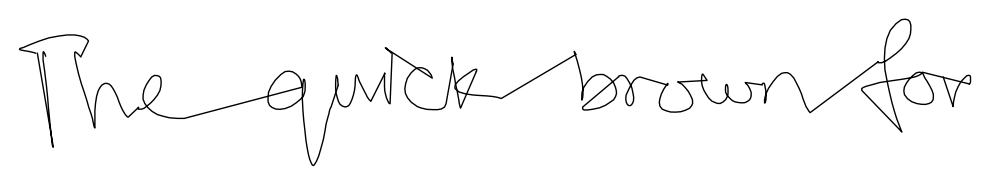

In [5]:
import json
import matplotlib.pyplot as plt

# Load the JSON data
with open('debug_logs/debug_request_20250507_112034.json', 'r') as file:
    data = json.load(file)

# Extract and group strokes by their "eos" flag
strokes = data['ref_strokes']
stroke_groups = []
current_group = []

for point in strokes:
    # Invert y-coordinate in the data itself
    current_group.append((point['x'], -point['y']))
    if point['eos'] == 1:
        if current_group:
            stroke_groups.append(current_group)
            current_group = []

# Create simple figure with white background
plt.figure(figsize=(10, 6))

# Plot each stroke in black
for stroke in stroke_groups:
    if len(stroke) > 1:
        x, y = zip(*stroke)
        plt.plot(x, y, 'k-', linewidth=1)

# Set equal aspect ratio
plt.gca().set_aspect('equal')

# Calculate bounds
all_points = [p for group in stroke_groups for p in group]
x_coords = [p[0] for p in all_points]
y_coords = [p[1] for p in all_points]
padding = 10
plt.xlim(min(x_coords) - padding, max(x_coords) + padding)
plt.ylim(min(y_coords) - padding, max(y_coords) + padding)

# Remove axes
plt.axis('off')

plt.tight_layout()
plt.show()

In [5]:
import requests

# API base URL
BASE_URL = "http://localhost:5000"

def test_handwriting():
    # Path to your test image
    image_path = "strokes.png"
    
    try:
        # Open and send the image
        with open(image_path, 'rb') as f:
            files = {'image': f}
            response = requests.post(f"{BASE_URL}/check_handwriting", files=files)
        
        # Print the response
        print("\nHandwriting Check Response:", response.json())
        
    except Exception as e:
        print("Error:", str(e))

def test_extract_text():
    # Path to your test image
    image_path = "strokes.png"
    
    try:
        # Open and send the image
        with open(image_path, 'rb') as f:
            files = {'image': f}
            response = requests.post(f"{BASE_URL}/extract_text", files=files)
        
        # Print the response
        print("\nText Extraction Response:", response.json())
        
    except Exception as e:
        print("Error:", str(e))

def test_compare_images():
    # Path to your test image
    image_path = "strokes.png"
    
    try:
        # Open and send the same image twice for comparison
        with open(image_path, 'rb') as f1, open(image_path, 'rb') as f2:
            files = [
                ('images[]', f1),
                ('images[]', f2)
            ]
            response = requests.post(f"{BASE_URL}/compare_images", files=files)
        
        # Print the response
        print("\nImage Comparison Response:", response.json())
        
    except Exception as e:
        print("Error:", str(e))

if __name__ == "__main__":
    print("Testing all APIs...")
    test_handwriting()
    test_extract_text()
    test_compare_images() 

Testing all APIs...

Handwriting Check Response: {'ok': True, 'result': False}

Text Extraction Response: {'ok': True, 'text': 'The quick brown fox'}

Image Comparison Response: {'comparison': 'The two images appear to be identical. They both show a stroke visualization with distinct strokes of a handwritten sentence "The quick brown fox". The strokes are colored with a gradient going from purple on the left to yellow on the right. The title of the image is "Stroke Visualization with Distinct Strokes".', 'ok': True}
